In [34]:
#import GPy
import time
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#from xgboost import plot_importance
from numpy import loadtxt
#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier
import scikitplot as skplt
#from pycaret.classification import *

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import warnings

warnings.filterwarnings("ignore")  # ignore DeprecationWarnings from tensorflow

import matplotlib.pyplot as plt

%matplotlib inline

import gpflow

from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter

#from multiclass_classification import plot_posterior_predictions, colors

# reproducibility:
np.random.seed(0)
tf.random.set_seed(123)
import warnings


warnings.warn("ignore")

In [3]:
X_train = np.load('X_train_afr_manual_w2v.npy')
y_train = np.load('y_train.npy').astype(int)
X_test = np.load('X_test_afr_manual_w2v.npy')
y_test = np.load('y_test.npy').astype(int)

In [4]:
y_train=y_train[:,np.newaxis]
y_test=y_test[:,np.newaxis]

In [5]:
data=(X_train,y_train)

## Using Squared Exponential Kernel
Sparse Classification model is built using RBF Kernel.
A total of 244 Inducing points are used while building the model.


In [6]:
### binary class 

In [40]:
M=1001
rbf_m = gpflow.models.SVGP(
    gpflow.kernels.SquaredExponential(),
    gpflow.likelihoods.Bernoulli(),
    gpflow.inducing_variables.InducingPoints(X_train[::M].copy()),
)

In [41]:
import warnings

warnings.filterwarnings("ignore")
warnings.warn("ignore")

In [42]:
%%time
rbf_training_loss_closure = rbf_m.training_loss_closure(data, compile=True)
rbf_elbo = lambda: -rbf_training_loss_closure().numpy()
print("RBF elbo before training: %.4e" % rbf_elbo())

RBF elbo before training: -2.4255e+05
CPU times: user 6.82 s, sys: 1.65 s, total: 8.47 s
Wall time: 3.43 s


In [43]:
import time

## Model Optimisation

In [44]:
%%time
set_trainable(rbf_m.inducing_variable, False)
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(
    rbf_training_loss_closure,
    variables=rbf_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": 100},
)
print(f"{res.nfev / (time.time() - start_time):.3f} iter/s")

### print accuracy 
train_acc = np.mean((rbf_m.predict_y(X_train)[0] > 0.5).numpy().astype("float") == y_train)
test_acc = np.mean((rbf_m.predict_y(X_test)[0] > 0.5).numpy().astype("float") == y_test)
print(f"Accuracy for {len(X_train[::M])} induced data points out of {len(X_train)} actual  data points")
print(f"Train acc  : {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("RBF elbo after training: %.4e" % rbf_elbo())


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0.311 iter/s
Accuracy for 244 induced data points out of 243994 actual  data points
Train acc  : 90.3620580833955%
Test acc : 90.26436006889837%
RBF elbo after training: -5.7970e+04
CPU times: user 49min 51s, sys: 7min 24s, total: 57min 16s
Wall time: 7min 8s


## Accuracy computation on test and training data

In [45]:
train_acc = np.mean((rbf_m.predict_y(X_train)[0] > 0.5).numpy().astype("float") == y_train)
test_acc = np.mean((rbf_m.predict_y(X_test)[0] > 0.5).numpy().astype("float") == y_test)
print(f"Accuracy with {len(X_train[::M])} induced data points ")
print(f"Train acc  : {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("RBF elbo after training: %.4e" % rbf_elbo())

Accuracy with 244 induced data points 
Train acc  : 90.3620580833955%
Test acc : 90.26436006889837%
RBF elbo after training: -5.7970e+04


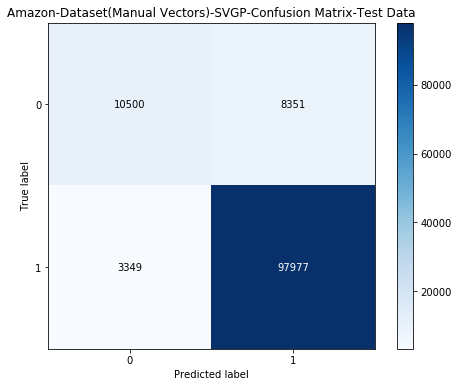

In [46]:
res = (rbf_m.predict_y(X_test)[0] > 0.5).numpy().astype("float")
skplt.metrics.plot_confusion_matrix(y_test, res)
plt.title("Amazon-Dataset(Manual Vectors)-SVGP-Confusion Matrix-Test Data")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

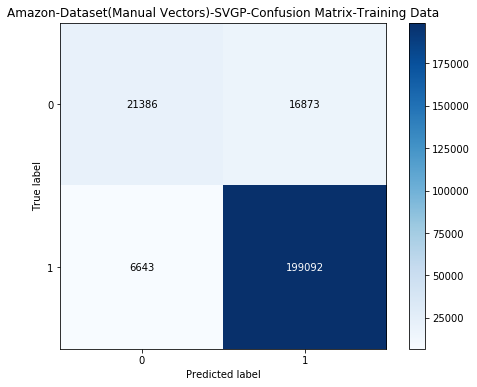

In [47]:
res_tr = (rbf_m.predict_y(X_train)[0] > 0.5).numpy().astype("float")
skplt.metrics.plot_confusion_matrix(y_train, res_tr)
plt.title("Amazon-Dataset(Manual Vectors)-SVGP-Confusion Matrix-Training Data")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

## Using centroids as induced points
K Means clustering is implemented on Data set and the centroids are extracted.A total of 1000 centroids are used as inducing points to the model.

In [26]:
# with centroids as inducing points 
from scipy import cluster
M = 500 #250 #1000
Z, distortion = cluster.vq.kmeans(X_train,M)

In [27]:
rbf_m = gpflow.models.SVGP(
    gpflow.kernels.SquaredExponential(),
    gpflow.likelihoods.Bernoulli(),
    gpflow.inducing_variables.InducingPoints(Z.copy()),
)

In [28]:
import warnings

warnings.filterwarnings("ignore")
warnings.warn("ignore")

In [29]:
%%time
rbf_training_loss_closure = rbf_m.training_loss_closure(data, compile=True)
rbf_elbo = lambda: -rbf_training_loss_closure().numpy()
print("RBF elbo before training: %.4e" % rbf_elbo())

RBF elbo before training: -2.4255e+05
CPU times: user 15.2 s, sys: 2.19 s, total: 17.4 s
Wall time: 7.62 s


## Model Optimisation

In [30]:
%%time
set_trainable(rbf_m.inducing_variable, False)
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(
    rbf_training_loss_closure,
    variables=rbf_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": 100},
)
print(f"{res.nfev / (time.time() - start_time):.3f} iter/s")

### print accuracy 
#train_acc = np.mean((rbf_m.predict_y(X_train)[0] > 0.5).numpy().astype("float") == y_train)
#test_acc = np.mean((rbf_m.predict_y(X_test)[0] > 0.5).numpy().astype("float") == y_test)
#print(f"Accuracy for {len(X_train[::M])} induced data points out of {len(X_train)} actual  data points")
#print(f"Train acc  : {train_acc * 100}%\nTest acc : {test_acc*100}%")
#print("RBF elbo after training: %.4e" % rbf_elbo())


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0.104 iter/s
Accuracy for 488 induced data points out of 243994 actual  data points
Train acc  : 90.09073993622793%
Test acc : 90.04052356108075%
RBF elbo after training: -5.9025e+04
CPU times: user 1h 52min 45s, sys: 15min 55s, total: 2h 8min 41s
Wall time: 22min 37s


## Accuracy when centroids are used as inducing points

In [31]:
train_acc = np.mean((rbf_m.predict_y(X_train)[0] > 0.5).numpy().astype("float") == y_train)
test_acc = np.mean((rbf_m.predict_y(X_test)[0] > 0.5).numpy().astype("float") == y_test)
print(f"Accuracy with {M} induced data points ")
print(f"Train acc  : {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("RBF elbo after training: %.4e" % rbf_elbo())

Accuracy with 500 induced data points 
Train acc  : 90.09073993622793%
Test acc : 90.04052356108075%
RBF elbo after training: -5.9025e+04


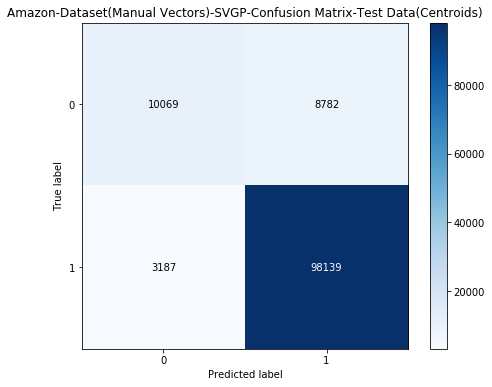

In [38]:
res = (rbf_m.predict_y(X_test)[0] > 0.5).numpy().astype("float")
skplt.metrics.plot_confusion_matrix(y_test, res)
plt.title("Amazon-Dataset(Manual Vectors)-SVGP-Confusion Matrix-Test Data(Centroids)")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

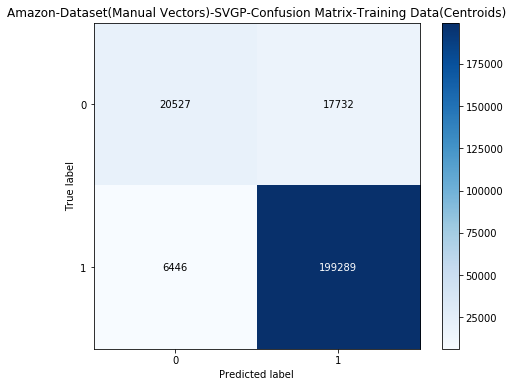

In [39]:
res_tr = (rbf_m.predict_y(X_train)[0] > 0.5).numpy().astype("float")
skplt.metrics.plot_confusion_matrix(y_train, res_tr)
plt.title("Amazon-Dataset(Manual Vectors)-SVGP-Confusion Matrix-Training Data(Centroids)")
plt.rcParams['figure.figsize']=(8,6)
plt.show()